<div align="center">
<b>PhD Dissertation Report</b>
<br><br>
David Noel<br>
Nova Southeastern University<br>
CISD 901: Doctoral Dissertation<br><br>
May, 2023
<br>
<br>
<b>Committee:</b> Dr. Sumitra Mukherjee (Chair), Dr. Michael Laszlo, Dr. Frank Mitropoulos
</div>

# Spatial invariance in Convolutional Neural Networks

Implementation of a data input pipeline for an investigation into spatial invariance in convolutional neural networks. Experiments will be carried out using:
1. 5 augmentation strategies (policies)
2. MNIST, FMNIST, CIFAR10
3. ResNet50, and InceptionV3

In [ ]:
# Enable for Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/

## Import Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.losses import CategoricalCrossentropy
from keras.utils import plot_model
from keras.optimizers import Adam,SGD
from keras.callbacks import (
    EarlyStopping,
    TerminateOnNaN,
    ModelCheckpoint,
    TensorBoard,
    ReduceLROnPlateau
)
import tensorflow_addons as tfa
import tensorflow_models as tfm
import tensorflow_datasets as tfds
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
import sys, math, time
import os
import shutil
import logging
from utils import generate_gan_samples, generate_gan_samples_onehot

print('Python version:', sys.version)
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

tfds.disable_progress_bar()
tf.get_logger().setLevel(logging.ERROR)

# Clear previous models from memory
tf.keras.backend.clear_session()

Python version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.10.1
GPU found at: /device:GPU:0


## Hyperparameters

In [3]:
EPOCHS = 100
NUMBER_POLICIES = 5
DATASET_NAME = "mnist"
NETWORK = "basic"
RESIZE_TO = (75, 75, 3) if NETWORK == "inception" else (32,32,3)
BATCH_SIZE = 512
AUTO = tf.data.AUTOTUNE
FOLDER = "." + os.sep + DATASET_NAME + os.sep + NETWORK

## Folders

In [4]:
# Removing the old folders generated during training
if os.path.exists(FOLDER):
    shutil.rmtree(FOLDER)

# Creating folders to save images, models and checkpoints
newpaths = [FOLDER]
for newpath in newpaths:
    if not os.path.exists(newpath):
        os.makedirs(newpath)

# Augmenter

### Define augmenter using RandAugment

In [5]:
exclude_list = ["Cutout"]
augmenter = tfm.vision.augment.RandAugment(num_layers=2, magnitude=9,translate_const=4, exclude_ops=exclude_list)

## Datasets

### Download benchmark dataset

In [6]:
(train_set, valid_set, test_set), info = tfds.load(
    "fashion_mnist" if DATASET_NAME == "fmnist" else DATASET_NAME,
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True,
    with_info=True,
    shuffle_files=True
)
# Extract informative features
class_names = info.features["label"].names
num_classes = info.features["label"].num_classes
input_shape = info.features['image'].shape
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = input_shape
NUM_TRAIN = len(train_set)
print("Image shape: {}".format(input_shape))
print("Classes: {}".format(class_names))
print("Number of classes: {}".format(num_classes))

Image shape: (28, 28, 1)
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of classes: 10


### Generate GAN dataset

In [7]:
# Generate GAN samples (regular labels from 0 to 9)
gan_set = generate_gan_samples(DATASET_NAME, NUM_TRAIN)
assert len(gan_set) == NUM_TRAIN, "GAN samples not generated correctly"
print("Generated {} GAN samples".format(len(gan_set)))

1688/1688 [==============================] - 10s 4ms/step
Generated 54000 GAN samples


### Dataset helper functions

In [8]:
def visualize_dataset(dataset, title="Dataset samples"):
    plt.figure().suptitle(title, fontsize=14)
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img = tf.keras.utils.array_to_img(images[i])
            plt.imshow(img)
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")
    plt.show()

In [9]:
def resize_and_rescale(image, label):
    # Add RGB channel
    image = tf.image.grayscale_to_rgb(image) if IMG_CHANNELS == 1 else image
    # Reshape without distortions
    image = tf.image.resize_with_pad(image, *RESIZE_TO[:2])
    # Convert to float32
    image = tf.cast(image, tf.float32)
    # One-hot encode labels
    label = tf.one_hot(label, num_classes)
    return image, label

In [10]:
def prepare_dataset(dataset, shuffle=False, augment=False):
    # Resize and rescale the dataset.
    dataset = dataset.map(resize_and_rescale, num_parallel_calls=AUTO).cache()
    # Shuffle the dataset.
    if shuffle:
        dataset = dataset.shuffle(len(dataset))
    # Batch the dataset.
    dataset = dataset.batch(BATCH_SIZE)
    # Augment the dataset using RandAugment.
    if augment:
        dataset = dataset.map(lambda x, y: (augmenter.distort(x), y), num_parallel_calls=AUTO)
    # Prefetch the dataset.
    return dataset.prefetch(AUTO)

### Preprocess datasets

In [11]:
# Validation dataset
val_ds = prepare_dataset(valid_set)
# Testing dataset
test_ds = prepare_dataset(test_set)
# Training dataset (policy 1)
train_ds = prepare_dataset(train_set, shuffle=True)
# Augmented training dataset (policy 2)
train_ds_aug = prepare_dataset(train_set, shuffle=True, augment=True)
# GAN dataset (policy 3)
gan_ds = prepare_dataset(gan_set, shuffle=True)
# GAN plus basic training dataset (policy 4).
# Combine the (shuffled) datasets randomly.
gan_train_ds = tf.data.Dataset.sample_from_datasets([train_ds, gan_ds], [0.5, 0.5])
# Augment GAN dataset (policy 5)
gan_ds_aug = prepare_dataset(gan_set, shuffle=True, augment=True)

### Visualize dataset

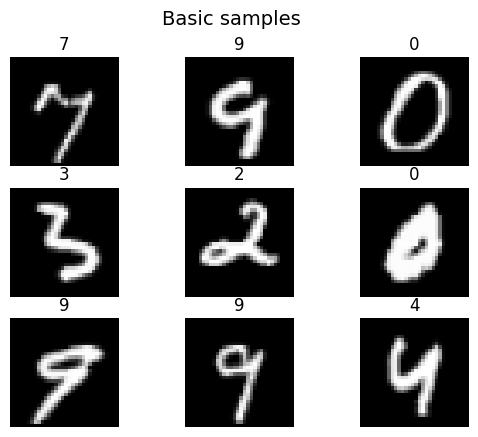

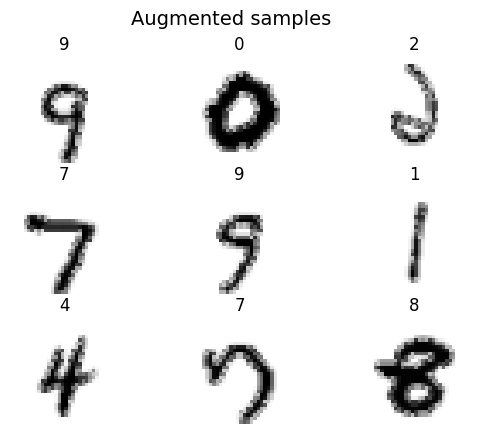

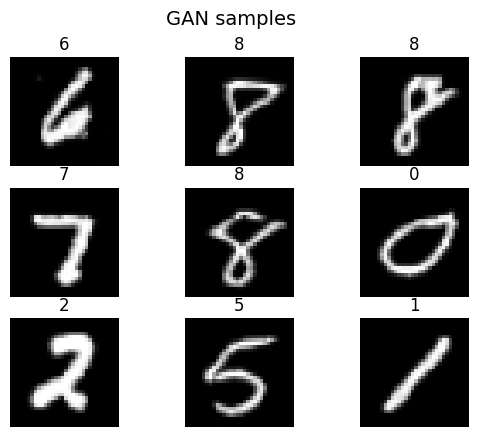

In [12]:
visualize_dataset(train_ds, title="Basic samples"),
visualize_dataset(train_ds_aug, title="Augmented samples"),
visualize_dataset(gan_ds, title="GAN samples")

## Helper Functions

In [13]:
# Create a basic CNN model
def get_basic_model():
    model = keras.Sequential(
        [
            keras.Input(shape=RESIZE_TO),
            keras.layers.Rescaling(scale=1.0 / 255.0),

            layers.Conv2D(32, kernel_size=3, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(32, kernel_size=3, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(32, kernel_size=5, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),

            layers.Conv2D(64, kernel_size=3, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, kernel_size=3, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, kernel_size=5, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.3),

            layers.Conv2D(128, kernel_size=3, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, kernel_size=3, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, kernel_size=5, activation="relu",padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.4),
            
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ],
        name="NoelNet",
    )
    return model

In [14]:
def get_training_model(model_name):
    '''Get model pre-trained on ImageNet'''
    if model_name == "basic":
        return get_basic_model()
    elif model_name == "resnet":
        network = tf.keras.applications.ResNet50V2(
            weights="imagenet",
            include_top=False,
            input_shape=RESIZE_TO,
        )
    elif model_name == "inception":
        network = tf.keras.applications.InceptionV3(
            weights="imagenet",
            include_top=False,
            input_shape=RESIZE_TO,
        )
    else:
        raise NotImplementedError("network not supported")

    model = tf.keras.Sequential(
        [
            keras.layers.Input(RESIZE_TO),
            keras.layers.Rescaling(scale=1.0 / 255.0),
            network,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(num_classes),
        ],
        name = model_name,
    )
    return model

In [15]:
def train_model(train_ds):
    '''Train model using the training dataset'''
    model = get_training_model(NETWORK)
    model.load_weights(INITIAL_WEIGHTS)
    model.compile(
        optimizer=Adam(),
        loss=CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    callbacks = [
        TerminateOnNaN(),
        ReduceLROnPlateau(factor=1/3.0),
        EarlyStopping(patience=40, restore_best_weights=True),
        ModelCheckpoint(
            filepath=FINAL_WEIGHTS, save_weights_only=True, save_best_only=True
        ),
    ]
    start = time.perf_counter()
    history = model.fit(
        train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks, verbose=1
    )
    latency = time.perf_counter() - start
    return [history, model, latency]

In [16]:
def plot_history(history, policy):
    # plot loss during training
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 6))
    fig.suptitle("Policy {} for {} on {}".format(policy, DATASET_NAME, NETWORK))
    ax1.set_title("Training Loss")
    ax1.plot(history.history["loss"], "--")
    ax1.plot(history.history["val_loss"], "--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(["training", "validation"], loc="best")
    # plot accuracy during training
    ax2.set_title("Training Accuracy")
    ax2.plot(history.history["accuracy"], "--")
    ax2.plot(history.history["val_accuracy"], "--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["training", "validation"], loc="best")
    # Save the figure
    plt.savefig(FOLDER + "/{}_{}_policy{}_plot.png".format(DATASET_NAME, NETWORK, policy))
    plt.show()

In [17]:
def get_performance_metrics(model,latency,policy):
    # Generate predictions
    predictions = model.predict(test_ds, verbose=0)
    # Get the predicted labels
    predictions = predictions.argmax(axis=1)
    # Get the true labels
    y_true = np.concatenate([y for _, y in test_ds]).argmax(axis=1)
    # Get the classification report
    report = classification_report(y_true, predictions, output_dict=True)
    print("\n**CLASSIFICATION REPORT**")
    print(pd.DataFrame(report).transpose())
    # Get the confusion matrix
    conf_matrix = confusion_matrix(y_true, predictions)
    print("\n**CONFUSION MATRIX**")
    print(pd.DataFrame(conf_matrix))
    # Get model metrics
    metrics = {
        "dataset": DATASET_NAME,
        "model": NETWORK,
        "params": NUMBER_PARAMETERS,
        "policy": policy,
        "accuracy": [report["accuracy"]],
        "precision": [report["macro avg"]["precision"]],
        "recall": [report["macro avg"]["recall"]],
        "f1score": [report["macro avg"]["f1-score"]],
        "latency": [latency],
    }
    return metrics

In [18]:
def save_to_csv(ds, metric):
    '''Save dataset to csv file'''
    file_name = FOLDER + f"/{DATASET_NAME}_{NETWORK}_{metric}.csv"
    results = []
    for i, item in enumerate(ds):
        # create and store dataframe
        df = pd.DataFrame(item.history) if metric == "history" else pd.DataFrame(item)
        results.append(df)
    # concatenate all dataframes
    results = pd.concat(results)
    # save to csv
    results.to_csv(file_name, index=False)

## Model
#### Instantiate model and save initial weights to file

Model: "NoelNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        2563

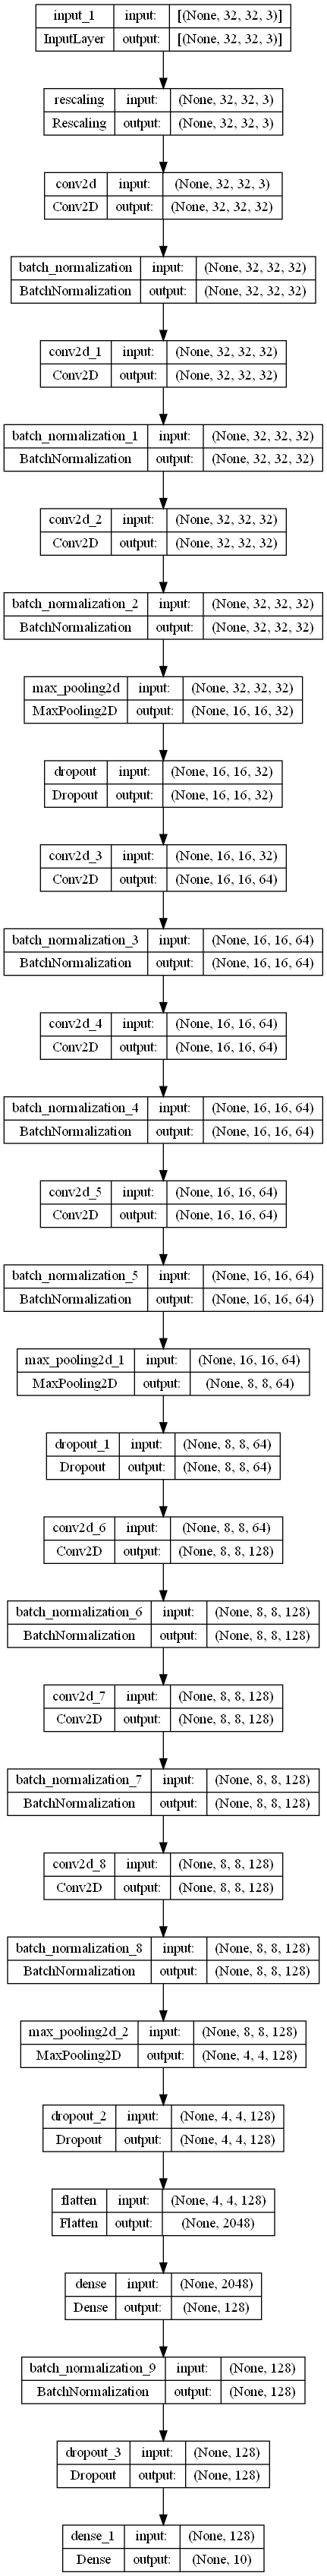

In [19]:
initial_model = get_training_model(NETWORK)
NUMBER_PARAMETERS = initial_model.count_params()
INITIAL_WEIGHTS = FOLDER + f"/{DATASET_NAME}_{NETWORK}_initial_weights.h5"
FINAL_WEIGHTS = FOLDER + f"/{DATASET_NAME}_{NETWORK}_final_weights.h5"
initial_model.summary()
# For reproducibility, we first save the initialize weights
initial_model.save_weights(INITIAL_WEIGHTS)
# Save network structure
plot_model(
    initial_model,
    show_shapes=True,
    show_layer_names=True,
    to_file=FOLDER + f"/{DATASET_NAME}_{NETWORK}_model.png",
)

## Training
#### Train model for each policy

In [ ]:
%%time
train_history = []
train_metrics = []
for i in range(1, 3):
    if i == 1:
        history, model, latency = train_model(train_ds)
    elif i == 2:
        history, model, latency = train_model(train_ds_aug)
    elif i == 3:
        history, model, latency = train_model(gan_ds)
    elif i == 4:
        history, model, latency = train_model(gan_train_ds)
    elif i == 5:
        history, model, latency = train_model(gan_ds_aug)
    else:
        raise NotImplementedError("Policy does not exist")
    # compute performance metrics
    metrics = get_performance_metrics(model, latency, i)
    # add policy number to history
    history.history["policy"] = [i] * len(history.history["loss"])
    # show plot for policy
    plot_history(history, i)
    # save history and metrics of policy to array
    train_history.append(history)
    train_metrics.append(metrics)
    # save model
    model.save(FOLDER + "/{}_{}_policy{}_model.h5".format(DATASET_NAME, NETWORK, i))

## Metrics
#### Save training metrics to file

In [ ]:
save_to_csv(train_metrics, "metrics")
save_to_csv(train_history, "history")